In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data=datasets.FashionMNIST(root='data',train=True,download=True,transform=ToTensor())

In [3]:
test_data=datasets.FashionMNIST(root='data',train=False,download=True,transform=ToTensor())

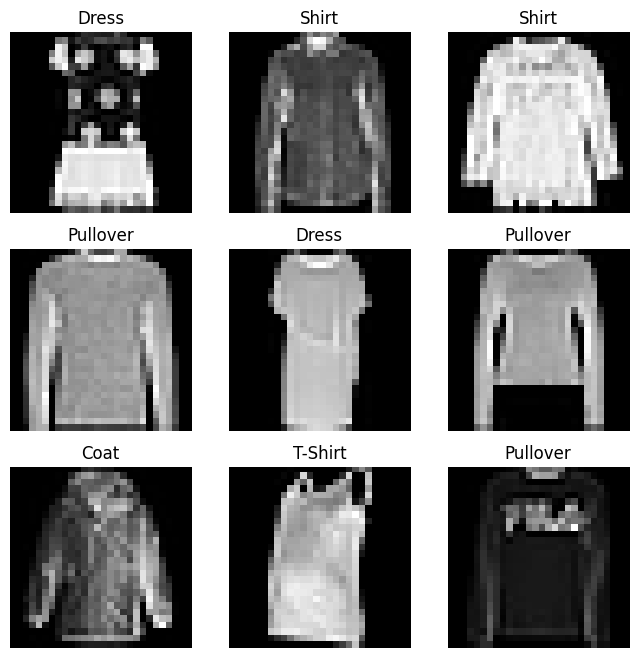

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure=plt.figure(figsize=(8,8))
cols,rows=3,3

for i in range(1,cols*rows+1):
    sample_idx=torch.randint(len(training_data),size=(1,)).item()
    img,label=training_data[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(),cmap="grey")
    
plt.show()    


### We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [5]:
batch_size=64

#create data loaders

train_dataloader=DataLoader(training_data,batch_size=batch_size)
test_dataloader=DataLoader(test_data,batch_size=batch_size)

for X,y in test_dataloader:
    print(f"Shape of X [N,C,H,W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break




Shape of X [N,C,H,W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Creating Models

### To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [7]:
#define model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten=nn.Flatten()
        self.linear_relu_stack=nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10),
            )
    def forward(self,x):
        x=self.flatten(x)
        logits=self.linear_relu_stack(x)
        return logits
    
model=NeuralNetwork().to(device)
print(model)        

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### To train a model, we need a loss function and an optimizer.

In [8]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=1e-3)

In [9]:
def train(dataloader,model,loss_fn,optimizer):
    size=len(dataloader.dataset)
    model.train()
    for batch,(X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        
        #error pred
        pred=model(X)
        loss=loss_fn(pred,y)
        
        #backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch%100==0:
            loss,current=loss.item(),(batch+1)*len(X)
            print(f"Loss: {loss} [{current},{size}]")

### We also check the model’s performance against the test dataset to ensure it is learning.

In [10]:
def test(dataloader,model,loss_fn):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    model.eval()
    test_loss,correct=0,0
    with torch.no_grad():
        for X,y in dataloader:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss/=num_batches
    correct/=size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
            

In [11]:
epochs=15
for t in range(epochs):
    print(f"Epoch {t+1}\n------------------------------")
    train(train_dataloader,model,loss_fn,optimizer)
    test(test_dataloader,model,loss_fn)
print("DONE!!!") 
    

Epoch 1
------------------------------
Loss: 2.298581600189209 [64,60000]
Loss: 2.2946863174438477 [6464,60000]
Loss: 2.275042772293091 [12864,60000]
Loss: 2.264369010925293 [19264,60000]
Loss: 2.2593376636505127 [25664,60000]
Loss: 2.226044178009033 [32064,60000]
Loss: 2.2249674797058105 [38464,60000]
Loss: 2.1949915885925293 [44864,60000]
Loss: 2.1834895610809326 [51264,60000]
Loss: 2.156869888305664 [57664,60000]
Test Error: 
 Accuracy: 51.6%, Avg loss: 2.155248 

Epoch 2
------------------------------
Loss: 2.1601920127868652 [64,60000]
Loss: 2.1619763374328613 [6464,60000]
Loss: 2.101477861404419 [12864,60000]
Loss: 2.11557674407959 [19264,60000]
Loss: 2.07550311088562 [25664,60000]
Loss: 2.008232355117798 [32064,60000]
Loss: 2.0306475162506104 [38464,60000]
Loss: 1.9542818069458008 [44864,60000]
Loss: 1.9550204277038574 [51264,60000]
Loss: 1.8862203359603882 [57664,60000]
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.887604 

Epoch 3
------------------------------
Loss: 1.9160603284

In [12]:
torch.save(model.state_dict(),"model.pth")
print("Saved PyTorch model state")

Saved PyTorch model state


In [13]:
model=NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth",weights_only=True))

<All keys matched successfully>

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [15]:
model.eval()
x,y=test_data[0][0],test_data[0][1]
with torch.no_grad():
    x=x.to(device)
    pred=model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
